## Задание
У нас есть данные АА-теста с '2023-01-24' по '2023-01-30'. Нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p-values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Прислать ссылку на merge request c проведенным анализом.

In [1]:
# импорт библиотек
import pandahouse
import seaborn as sns
from scipy import stats
from random import sample
import numpy as np

In [2]:
# для соединения с БД
connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': '************',
'user': '*********',
'database': 'simulator_20230220'
}

In [3]:
# достаем пользователей и их характеристики из 2 группы
q_users_2_group = """
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    simulator_20230220.feed_actions 
WHERE 
    toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group = 2
GROUP BY
    exp_group, 
    user_id
"""

users_2_group_df = pandahouse.read_clickhouse(q_users_2_group, connection=connection)

users_2_group_df.head()

,exp_group,user_id,likes,views,ctr
0,2,131473,26,148,0.175676
1,2,23985,12,66,0.181818
2,2,24523,17,120,0.141667
3,2,24239,53,119,0.445378
4,2,14680,8,70,0.114286


In [4]:
# по привычке смотрим общее описание полученного датафрейма
users_2_group_df.describe()

,exp_group,user_id,likes,views,ctr
count,8480.0,8480.000000,8480.000000,8480.000000,8480.000000
mean,2.0,69282.766981,15.534198,73.493868,0.218246
std,0.0,53428.421103,10.814642,48.332066,0.080643
min,2.0,218.000000,0.000000,1.000000,0.000000
25%,2.0,16156.750000,7.000000,36.000000,0.164451
50%,2.0,107779.500000,13.000000,64.000000,0.205882
75%,2.0,121660.000000,21.000000,100.000000,0.260870
max,2.0,133642.000000,83.000000,364.000000,0.714286


In [5]:
# достаем пользователей и их характеристики из 3 группы
q_users_3_group = """
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    simulator_20230220.feed_actions 
WHERE 
    toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group = 3
GROUP BY
    exp_group,
    user_id
"""

users_3_group_df = pandahouse.read_clickhouse(q_users_3_group, connection=connection)

users_3_group_df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,3,19647,21,146,0.143836
3,3,107670,25,115,0.217391
4,3,126702,3,12,0.250000


In [6]:
# по привычке смотрим общее описание полученного датафрейма
users_3_group_df.describe()

,exp_group,user_id,likes,views,ctr
count,8569.0,8569.000000,8569.000000,8569.000000,8569.000000
mean,3.0,69522.305520,15.612790,74.097678,0.219161
std,0.0,53281.229624,10.663215,49.081302,0.080932
min,3.0,200.000000,0.000000,2.000000,0.000000
25%,3.0,16332.000000,8.000000,36.000000,0.166667
50%,3.0,108007.000000,13.000000,64.000000,0.206612
75%,3.0,121563.000000,21.000000,102.000000,0.261538
max,3.0,133635.000000,83.000000,369.000000,0.714286


**В группах 2 и 3 приблизительно одинаковое количество пользователей, очень близкие значения средних, стандартного отклонения, медианы.  
Нулевая гипотеза (Н0): Система сплитования работает корректно, группы 2 и 3 приблизительно одинаковые.  
Альтернативная гипотеза (Н1): Система сплитования работает некорректно, в группах 2 и 3 имеются значимые различия.  
Продолжаем анализ.**

In [7]:
# формируем подвыборку по 500 пользователей из каждой группы (без повторения), проводим Т-тест, записываем p-value,
# повторяем 10000 раз 

p_values = []
for i in range(10000):
    samples_2_group = users_2_group_df.sample(500, replace=False)
    samples_3_group = users_3_group_df.sample(500, replace=False)
    t_test = stats.ttest_ind(samples_2_group.ctr, samples_3_group.ctr, equal_var=False)
    p_values.append(t_test[1])

In [8]:
# проверяем длину полученного списка p-value
len(p_values)

10000

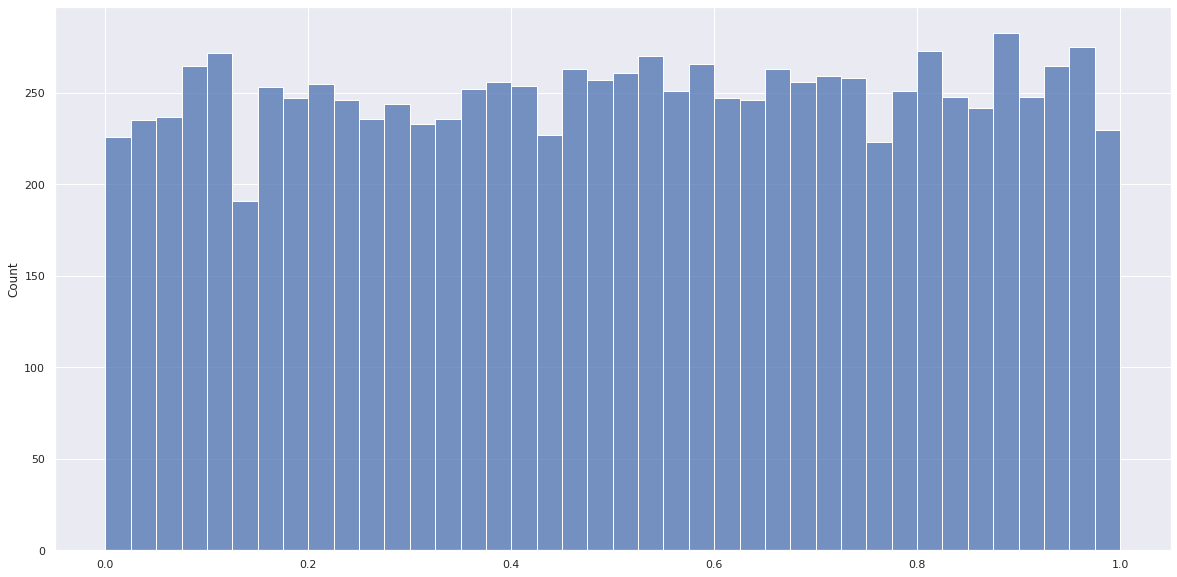

In [9]:
# Строим гистограмму распределения получившихся 10000 p-values

sns.set(rc={'figure.figsize':(20,10)})

groups = sns.histplot(data = p_values, 
             stat='count', bins=40)

In [10]:
# Считаем количество p-value менее 0,05

count_for_005 = 0
for el in p_values:
    if el <= 0.05:
        count_for_005 += 1
count_for_005

458

In [11]:
# Считаем процент p-value менее 0,05
percent_for_005 = 100 * count_for_005 / len(p_values)
f'{percent_for_005} % p-values оказались меньше или равны 0,05'

'4.58 % p-values оказались меньше или равны 0,05'

## Обсуждение результатов
**Итак, при оценке полученных p-values у нас получилось непрерывное равномерное распределение (uniform distribution), 4.74 % p-values оказались меньше или равны 0,05.  
Следовательно, нулевая гипотеза верна и система сплитования работает корректно, ключевая метрика не отличается между группами.**